In [25]:
#Import Required Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve

from imblearn.over_sampling import SMOTE  # for imbalance handling

In [26]:
# 2. Load Dataset
df = pd.read_csv("/content/Telco-Customer-Churn.csv")

print(df.head())
print(df.info())

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

In [27]:
# Data Preprocessing
# Drop customerID
df.drop("customerID", axis=1, inplace=True)

# Convert TotalCharges to numeric (sometimes stored as string)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Handle missing values
df.fillna(df.median(numeric_only=True), inplace=True)

# Encode categorical features
for col in df.select_dtypes(include="object").columns:
    if col != "Churn":
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])

# Encode target
df["Churn"] = df["Churn"].map({"Yes":1, "No":0})

print(df.head())

   gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0       0              0        1           0       1             0   
1       1              0        0           0      34             1   
2       1              0        0           0       2             1   
3       1              0        0           0      45             0   
4       0              0        0           0       2             1   

   MultipleLines  InternetService  OnlineSecurity  OnlineBackup  \
0              1                0               0             2   
1              0                0               2             0   
2              0                0               2             2   
3              1                0               2             0   
4              0                1               0             0   

   DeviceProtection  TechSupport  StreamingTV  StreamingMovies  Contract  \
0                 0            0            0                0         0   
1                 

In [28]:
#Train-Test Split
X = df.drop("Churn", axis=1)
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Train Churn %:", y_train.mean())
print("Test Churn %:", y_test.mean())

Train Churn %: 0.2653144016227181
Test Churn %: 0.26549929010885


In [29]:
#Handle Class Imbalance

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts(normalize=True))
print("After SMOTE:", y_train_res.value_counts(normalize=True))

Before SMOTE: Churn
0    0.734686
1    0.265314
Name: proportion, dtype: float64
After SMOTE: Churn
0    0.5
1    0.5
Name: proportion, dtype: float64


In [30]:
#Logistic Regression Model

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

log_reg = LogisticRegression(max_iter=500, class_weight="balanced")
log_reg.fit(X_train_scaled, y_train_res)

y_pred_lr = log_reg.predict(X_test_scaled)
y_proba_lr = log_reg.predict_proba(X_test_scaled)[:,1]

print("Logistic Regression ROC-AUC:", roc_auc_score(y_test, y_proba_lr))
print(classification_report(y_test, y_pred_lr))

Logistic Regression ROC-AUC: 0.8243500422662033
              precision    recall  f1-score   support

           0       0.89      0.76      0.82      1552
           1       0.53      0.73      0.61       561

    accuracy                           0.75      2113
   macro avg       0.71      0.75      0.72      2113
weighted avg       0.79      0.75      0.76      2113



In [31]:
# Random Forest Model

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    class_weight="balanced",
    random_state=42
)

rf.fit(X_train_res, y_train_res)

y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:,1]

print("Random Forest ROC-AUC:", roc_auc_score(y_test, y_proba_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest ROC-AUC: 0.8292795679658929
              precision    recall  f1-score   support

           0       0.88      0.81      0.84      1552
           1       0.56      0.68      0.62       561

    accuracy                           0.78      2113
   macro avg       0.72      0.75      0.73      2113
weighted avg       0.79      0.78      0.78      2113



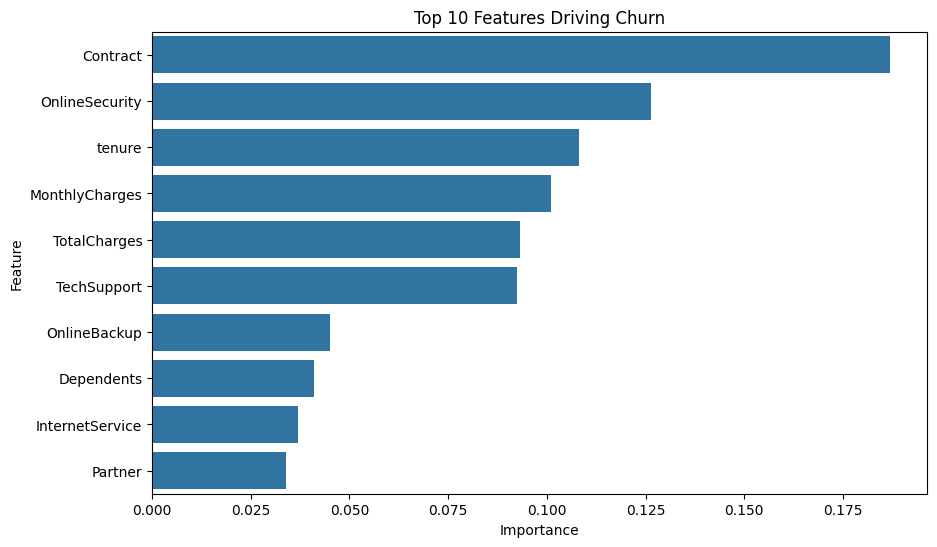

            Feature  Importance
14         Contract    0.186940
8    OnlineSecurity    0.126493
4            tenure    0.108136
17   MonthlyCharges    0.100973
18     TotalCharges    0.093220
11      TechSupport    0.092551
9      OnlineBackup    0.044956
3        Dependents    0.040926
7   InternetService    0.036995
2           Partner    0.033990


In [32]:
# Feature Importance (Business Insights)

feat_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=feat_importance.head(10))
plt.title("Top 10 Features Driving Churn")
plt.show()

print(feat_importance.head(10))

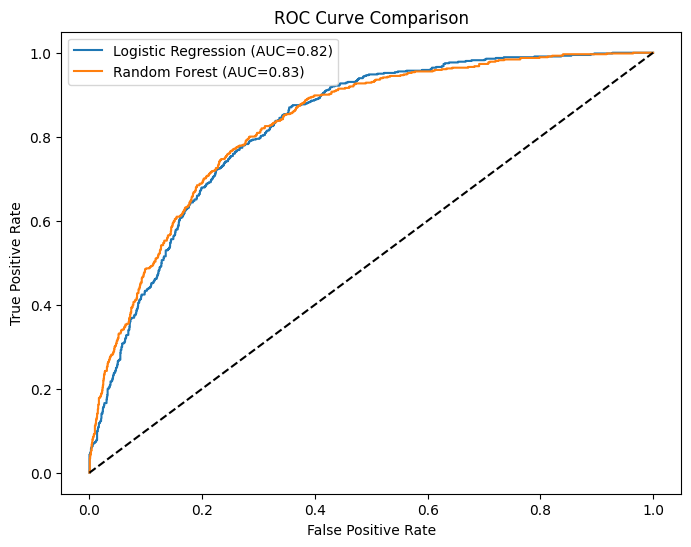

In [33]:
# ROC Curve Visualization

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

plt.figure(figsize=(8,6))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC={roc_auc_score(y_test, y_proba_lr):.2f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC={roc_auc_score(y_test, y_proba_rf):.2f})")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

In [34]:
# Save Model for Deployment

import joblib

#joblib.dump(rf, "churn_model_rf.pkl")
joblib.dump(log_reg, "churn_model_lr.pkl")
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [35]:
#check fature names
print(rf.feature_names_in_)

['gender' 'SeniorCitizen' 'Partner' 'Dependents' 'tenure' 'PhoneService'
 'MultipleLines' 'InternetService' 'OnlineSecurity' 'OnlineBackup'
 'DeviceProtection' 'TechSupport' 'StreamingTV' 'StreamingMovies'
 'Contract' 'PaperlessBilling' 'PaymentMethod' 'MonthlyCharges'
 'TotalCharges']


In [36]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_features = [
    'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
    'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
    'Contract', 'PaperlessBilling', 'PaymentMethod'
]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

model.fit(X_train, y_train)
joblib.dump(model, 'churn_model_rf.pkl')

['churn_model_rf.pkl']